<a href="https://colab.research.google.com/github/ArtemVazh/Neural-Tensor-Network/blob/main/Tensor_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorly

     |████████████████████████████████| 112kB 14.9MB/s 
     |████████████████████████████████| 163kB 23.3MB/s 
  Created wheel for tensorly: filename=tensorly-0.5.1-cp36-none-any.whl size=149168 sha256=de77b8d89ef7fbdc23ac25dbbcc0a5b94b94e6e5b66cb6a2d5a76009d82483e1
  Stored in directory: /root/.cache/pip/wheels/88/1e/e7/b9677b2046cc87e17931b4b5781941786d3ee647825ca40ea6
Successfully built tensorly


In [ ]:
import torch
import torchvision

In [ ]:
import numpy as np
import tensorly as tl
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tl.set_backend('pytorch')

In [ ]:
batch_size_train=32
batch_size_test=100
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [ ]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.CIFAR100('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.Resize(224),      
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.CIFAR100('/files/', train=False, download=False,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.Resize(224),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

Extracting /files/cifar-100-python.tar.gz to /files/


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

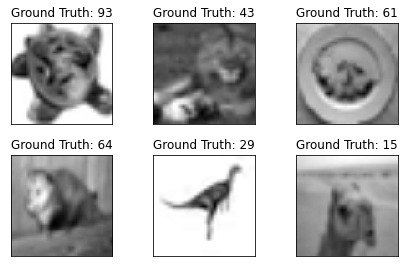

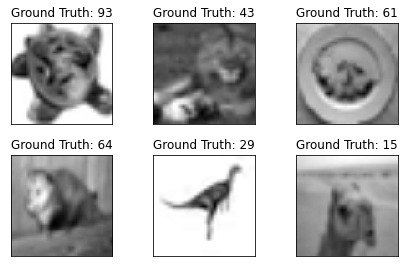

In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [ ]:
import torchvision.models as models
resnet50 = models.resnet50()

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

n_epochs = 50
batch_size_train = 32
batch_size_test = 1000
learning_rate = 0.01
log_interval = 50


class TaylorNet1(nn.Module):
    def __init__(self):
        super().__init__() #Net, self
        self.resnet = models.resnet18(pretrained=True)
        self.fc = nn.Linear(self.resnet.fc.in_features, 100)#TensorLayer2order(resnet.fc.in_features, 100, rank=50, alpha=1e-2)
        self.resnet.fc = nn.Identity(self.resnet.fc.in_features)
 
    def forward(self, x):
        x = F.relu(self.resnet(x))
        x = self.fc.forward(x)
        return F.log_softmax(x)

In [ ]:
network = TaylorNet1().to(device)
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data.to(device))
    loss = F.nll_loss(output.cpu(), target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      # torch.save(network.state_dict(), '/results/model.pth')
      # torch.save(optimizer.state_dict(), '/results/optimizer.pth')


def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data.to(device))
      test_loss += F.nll_loss(output.cpu(), target, size_average=False).item()
      pred = output.cpu().data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
%%time

test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 4.7693, Accuracy: 107/10000 (1%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 4.757212
Train Epoch: 1 [1600/50000 (3%)]	Loss: 4.797309
Train Epoch: 1 [3200/50000 (6%)]	Loss: 4.655113
Train Epoch: 1 [4800/50000 (10%)]	Loss: 4.538601
Train Epoch: 1 [6400/50000 (13%)]	Loss: 4.580159
Train Epoch: 1 [8000/50000 (16%)]	Loss: 4.524429
Train Epoch: 1 [9600/50000 (19%)]	Loss: 4.573866
Train Epoch: 1 [11200/50000 (22%)]	Loss: 4.385666
Train Epoch: 1 [12800/50000 (26%)]	Loss: 4.360825
Train Epoch: 1 [14400/50000 (29%)]	Loss: 4.285050
Train Epoch: 1 [16000/50000 (32%)]	Loss: 4.470148
Train Epoch: 1 [17600/50000 (35%)]	Loss: 4.434677
Train Epoch: 1 [19200/50000 (38%)]	Loss: 4.388521
Train Epoch: 1 [20800/50000 (42%)]	Loss: 4.113019
Train Epoch: 1 [22400/50000 (45%)]	Loss: 4.021833
Train Epoch: 1 [24000/50000 (48%)]	Loss: 4.263037
Train Epoch: 1 [25600/50000 (51%)]	Loss: 4.272202
Train Epoch: 1 [27200/50000 (54%)]	Loss: 4.066744
Train Epoch: 1 [28800/50000 (58%)]	Loss: 4.426696
Train E

In [ ]:
class TensorLayer2order(torch.nn.Module):
    def __init__(self, n_input, n_output, rank = 200, alpha=1e-1):
        super(TensorLayer2order, self).__init__()
        self.rank = rank 
        self.V = torch.nn.Parameter(torch.randn(n_input, n_output, requires_grad=True, dtype=torch.float32), requires_grad=True)
        self.B = torch.nn.Parameter(torch.randn(1, n_output, requires_grad=True, dtype=torch.float32), requires_grad=True)
 
        weight = torch.randn(rank, dtype=torch.float32)
        factors1 = torch.randn(n_input, rank, dtype=torch.float32)
        factors2 = torch.randn(n_input, rank, dtype=torch.float32)
        factors3 = torch.randn(n_output, rank, dtype=torch.float32)
        factors = [factors1, factors2, factors3]
 
        self.weight = torch.nn.Parameter(weight, requires_grad=True)
        self.factors1 = torch.nn.Parameter(factors[0], requires_grad=True)
        self.factors2 = torch.nn.Parameter(factors[1], requires_grad=True)
        self.factors3 = torch.nn.Parameter(factors[2], requires_grad=True)
 
        self.alpha = alpha
 
        self.E = None
 
    def forward(self, E):
        weight = self.weight.to(device)
        factors1 = self.factors1.to(device)
        factors2 = self.factors2.to(device)
        factors3 = self.factors3.to(device)
 
        batch_size = E.shape[0]
        tensor_output = torch.zeros(size=(E.shape[0], factors3.shape[0])).to(device)
 
        for batch in range(batch_size): 
            M1 = tl.cp_mode_dot((weight, [factors1, factors2, factors3]), E[np.newaxis, batch, :], 0, copy=True)
            M1 = tl.cp_tensor.cp_to_unfolded(M1, 1)
            tensor_output[batch] = (E[np.newaxis, batch,:] @ M1)[0].to(device)
 
        V = self.V.to(device)
        B = self.B.to(device)
        self.E = E.clone().detach().requires_grad_(True)
 
        self.out = B + E@V + self.alpha*tensor_output.to(device)

        print(factors1[0, 0], factors2[0, 0], factors3[0, 0])

        return self.out
 
 
class TensorLayer3order(torch.nn.Module):
    def __init__(self, n_input, n_output, rank = 50, alpha2=1e-1, alpha3=1e-2):
        super(TensorLayer3order, self).__init__()
        self.rank = rank
        self.V = torch.nn.Parameter(torch.randn(n_input, n_output, requires_grad=True, dtype=torch.float32), requires_grad=True)
        self.B = torch.nn.Parameter(torch.randn(1, n_output, requires_grad=True, dtype=torch.float32), requires_grad=True)
 
        weight1 = torch.randn(rank, dtype=torch.float32)
        factors1 = torch.randn(n_input, rank, dtype=torch.float32)
        factors2 = torch.randn(n_input, rank, dtype=torch.float32)
        factors3 = torch.randn(n_output, rank, dtype=torch.float32)
        factors1 = [factors1, factors2, factors3]
 
        self.weight1 = torch.nn.Parameter(weight1, requires_grad=True)
        self.factors1 = torch.nn.Parameter(factors1[0], requires_grad=True)
        self.factors2 = torch.nn.Parameter(factors1[1], requires_grad=True)
        self.factors3 = torch.nn.Parameter(factors1[2], requires_grad=True)
 
        weight2 = torch.randn(rank, dtype=torch.float32)
        factors21 = torch.randn(n_input, rank, dtype=torch.float32)
        factors22 = torch.randn(n_input, rank, dtype=torch.float32)
        factors23 = torch.randn(n_input, rank, dtype=torch.float32)
        factors24 = torch.randn(n_output, rank, dtype=torch.float32)
        factors2 = [factors21, factors22, factors23, factors24]
 
        self.weight2 = torch.nn.Parameter(weight2, requires_grad=True)
        self.factors21 = torch.nn.Parameter(factors2[0], requires_grad=True)
        self.factors22 = torch.nn.Parameter(factors2[1], requires_grad=True)
        self.factors23 = torch.nn.Parameter(factors2[2], requires_grad=True)
        self.factors24 = torch.nn.Parameter(factors2[3], requires_grad=True)
 
        self.alpha2 = alpha2
        self.alpha3 = alpha3
 
        self.E = None
 
    def forward(self, E):
        weight1 = self.weight1.to(device)
        factors1 = self.factors1.to(device)
        factors2 = self.factors2.to(device)
        factors3 = self.factors3.to(device)
 
        weight2 = self.weight2.to(device)
        factors21 = self.factors21.to(device)
        factors22 = self.factors22.to(device)
        factors23 = self.factors23.to(device)
        factors24 = self.factors24.to(device)
 
        batch_size = E.shape[0]
        tensor_output_2 = torch.zeros(size=(E.shape[0], factors3.shape[0])).to(device)
        tensor_output_3 = torch.zeros(size=(E.shape[0], factors3.shape[0])).to(device)
 
        P_cpd = (weight2, [factors21, factors22, factors23, factors24])
        for batch in range(batch_size): 
            M1 = tl.cp_mode_dot((weight1, [factors1, factors2, factors3]), E[np.newaxis, batch, :], 0, copy=True)
            M1 = tl.cp_tensor.cp_to_unfolded(M1, 1)
            tensor_output_2[batch] = (E[np.newaxis, batch,:] @ M1)[0].to(device)
          
            P1 = tl.cp_mode_dot(tl.cp_mode_dot(tl.cp_mode_dot(P_cpd, E[np.newaxis, batch,:], 0, copy=True), E[np.newaxis, batch,:], 1), E[np.newaxis, batch,:], 2)
            P1 = tl.cp_tensor.cp_to_unfolded(P1, 1)
            tensor_output_3[batch] = P1[0].to(device)
 
        V = self.V.to(device)
        B = self.B.to(device)
        self.E = E.clone().detach().requires_grad_(True)
        self.out = B + E@V + self.alpha2*tensor_output_2.to(device) + self.alpha3*tensor_output_3.to(device)
        return self.out
 
 
class TaylorNet2(nn.Module):
    def __init__(self, alpha=1e-2):
        super().__init__() #Net, self
        self.resnet = models.resnet18(pretrained=True)
        self.fc = TensorLayer2order(self.resnet.fc.in_features, 100, rank=100, alpha=alpha)
        self.resnet.fc = nn.Identity(self.resnet.fc.in_features)
 
    def forward(self, x):
        x = F.relu(self.resnet(x))
        x = self.fc.forward(x)
        return F.log_softmax(x)

In [ ]:
network = TaylorNet2().to(device)
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [ ]:
%%time

batch_size_train = 32
batch_size_test = 1000
log_interval = 50
 
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)
 
network = network.float()


 
n_epochs = 50
learning_rate = 0.01
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:124: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 151.7739, Accuracy: 92/10000 (1%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 184.506424
Train Epoch: 1 [1600/50000 (3%)]	Loss: 17.900438
Train Epoch: 1 [3200/50000 (6%)]	Loss: 7.723359
Train Epoch: 1 [4800/50000 (10%)]	Loss: 7.146815
Train Epoch: 1 [6400/50000 (13%)]	Loss: 6.763273
Train Epoch: 1 [8000/50000 (16%)]	Loss: 5.178904
Train Epoch: 1 [9600/50000 (19%)]	Loss: 5.462395
Train Epoch: 1 [11200/50000 (22%)]	Loss: 5.386594
Train Epoch: 1 [12800/50000 (26%)]	Loss: 6.426482
Train Epoch: 1 [14400/50000 (29%)]	Loss: 5.578983
Train Epoch: 1 [16000/50000 (32%)]	Loss: 5.479034
Train Epoch: 1 [17600/50000 (35%)]	Loss: 7.297489
Train Epoch: 1 [19200/50000 (38%)]	Loss: 5.258080
Train Epoch: 1 [20800/50000 (42%)]	Loss: 5.217166
Train Epoch: 1 [22400/50000 (45%)]	Loss: 5.252903
Train Epoch: 1 [24000/50000 (48%)]	Loss: 6.407718
Train Epoch: 1 [25600/50000 (51%)]	Loss: 6.966873
Train Epoch: 1 [27200/50000 (54%)]	Loss: 5.346340
Train Epoch: 1 [28800/50000 (58%)]	Loss: 6.096829
Tra

In [ ]:
class TaylorNet3(nn.Module):
    def __init__(self, alpha=1e-2):
        super().__init__() #Net, self
        self.resnet = models.resnet18(pretrained=True)
        self.fc = TensorLayer3order(self.resnet.fc.in_features, 100, rank=50, alpha2=alpha, alpha3=alpha/10)
        self.resnet.fc = nn.Identity(self.resnet.fc.in_features)
 
    def forward(self, x):
        x = F.relu(self.resnet(x))
        x = self.fc.forward(x)
        return F.log_softmax(x)


def train_network(alpha, net_order=2):
  batch_size_train = 32
  batch_size_test = 1000
  log_interval = 200

  random_seed = 1
  torch.backends.cudnn.enabled = False
  torch.manual_seed(random_seed)

  # network = network.float()

  n_epochs = 50
  learning_rate = 0.01


  if net_order==2:
    network = TaylorNet2(alpha).to(device)
  if net_order==3:
    network = TaylorNet3(alpha).to(device)
    
  optimizer = optim.Adam(network.parameters(), lr=learning_rate)

  train_losses = []
  train_counter = []
  test_losses = []
  test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

  network = network.float()
  def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
      optimizer.zero_grad()
      output = network(data.to(device))
      loss = F.nll_loss(output.cpu(), target)
      loss.backward()
      optimizer.step()
      if batch_idx % log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))
        train_losses.append(loss.item())
        train_counter.append(
          (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
        # torch.save(network.state_dict(), '/results/model.pth')
        # torch.save(optimizer.state_dict(), '/results/optimizer.pth')


  def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
      for data, target in test_loader:
        output = network(data.to(device))
        test_loss += F.nll_loss(output.cpu(), target, size_average=False).item()
        pred = output.cpu().data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))

  test()
  for epoch in range(1, n_epochs + 1):
    train(epoch)
    if epoch % 5 == 0:
        test()

  test()

  return network

In [ ]:
train_network(0.01, net_order=3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 272.3665, Accuracy: 139/10000 (1%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 297.812439
Train Epoch: 1 [6400/50000 (13%)]	Loss: 8.217883
Train Epoch: 1 [12800/50000 (26%)]	Loss: 7.345639
Train Epoch: 1 [19200/50000 (38%)]	Loss: 8.878364
Train Epoch: 1 [25600/50000 (51%)]	Loss: 10.190687
Train Epoch: 1 [32000/50000 (64%)]	Loss: 8.028220
Train Epoch: 1 [38400/50000 (77%)]	Loss: 7.062696
Train Epoch: 1 [44800/50000 (90%)]	Loss: 6.254453
Train Epoch: 2 [0/50000 (0%)]	Loss: 7.668292
Train Epoch: 2 [6400/50000 (13%)]	Loss: 5.484321
Train Epoch: 2 [12800/50000 (26%)]	Loss: 6.005161
Train Epoch: 2 [19200/50000 (38%)]	Loss: 6.237216
Train Epoch: 2 [25600/50000 (51%)]	Loss: 4.670682
Train Epoch: 2 [32000/50000 (64%)]	Loss: 5.449220
Train Epoch: 2 [38400/50000 (77%)]	Loss: 7.016248
Train Epoch: 2 [44800/50000 (90%)]	Loss: 5.773447
Train Epoch: 3 [0/50000 (0%)]	Loss: 6.254147
Train Epoch: 3 [6400/50000 (13%)]	Loss: 5.091000
Train Epoch: 3 [12800/50000 (26%)]	Loss: 6.787210
Train E

TaylorNet3(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [ ]:
train_network(0.1, net_order=3)
train_network(0.0001, net_order=3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2652.9166, Accuracy: 109/10000 (1%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2822.470215
Train Epoch: 1 [6400/50000 (13%)]	Loss: 10.175269
Train Epoch: 1 [12800/50000 (26%)]	Loss: 6.366731
Train Epoch: 1 [19200/50000 (38%)]	Loss: 6.715982
Train Epoch: 1 [25600/50000 (51%)]	Loss: 7.739859
Train Epoch: 1 [32000/50000 (64%)]	Loss: 4.641117
Train Epoch: 1 [38400/50000 (77%)]	Loss: 6.671415
Train Epoch: 1 [44800/50000 (90%)]	Loss: 7.226266
Train Epoch: 2 [0/50000 (0%)]	Loss: 7.825795
Train Epoch: 2 [6400/50000 (13%)]	Loss: 11.866676
Train Epoch: 2 [12800/50000 (26%)]	Loss: 8.217197
Train Epoch: 2 [19200/50000 (38%)]	Loss: 8.629228
Train Epoch: 2 [25600/50000 (51%)]	Loss: 12.322107
Train Epoch: 2 [32000/50000 (64%)]	Loss: 10.785400
Train Epoch: 2 [38400/50000 (77%)]	Loss: 4.890011
Train Epoch: 2 [44800/50000 (90%)]	Loss: 6.303481
Train Epoch: 3 [0/50000 (0%)]	Loss: 5.312116
Train Epoch: 3 [6400/50000 (13%)]	Loss: 6.990715
Train Epoch: 3 [12800/50000 (26%)]	Loss: 8.907968
Tr

TaylorNet3(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r